# Autoencoder for Anomaly Detection on CICIDS2017

This notebook trains an Autoencoder for anomaly detection on the CICIDS2017 dataset.

**Model:** Autoencoder (PyTorch)  
**Dataset:** CICIDS2017  
**Task:** Anomaly Detection (Benign vs Attack based on reconstruction error)

## 1. Setup and Imports

In [1]:
import sys
sys.path.insert(0, '../..')

import numpy as np
import pandas as pd
import glob
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


## 2. Load and Preprocess Data

In [2]:
# Load all CSV files from the CICIDS2017 raw directory
DATA_PATH = '../../data/raw/cicids2017/'
all_files = glob.glob(os.path.join(DATA_PATH, "*.csv"))

print(f"Found {len(all_files)} files.")
li = []

for filename in all_files:
    print(f"Loading {os.path.basename(filename)}...")
    df_temp = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_temp)

# Concatenate
df = pd.concat(li, axis=0, ignore_index=True)
print(f"Total raw samples: {len(df):,}")

# Garbage collection to free memory
del li
gc.collect()

Found 8 files.
Loading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
Loading Friday-WorkingHours-Morning.pcap_ISCX.csv...
Loading Monday-WorkingHours.pcap_ISCX.csv...
Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
Loading Tuesday-WorkingHours.pcap_ISCX.csv...
Loading Wednesday-workingHours.pcap_ISCX.csv...
Total raw samples: 2,830,743


0

In [3]:
# Basic Cleaning
# 1. Strip whitespace from column names
df.columns = df.columns.str.strip()

# 2. Replace Inf with NaN and drop NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print(f"Samples after dropping NaN/Inf: {len(df):,}")

# 3. Drop administrative columns if they exist
drop_cols = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

print("Remaining columns:", len(df.columns))

Samples after dropping NaN/Inf: 2,827,876
Remaining columns: 78


In [4]:
# Create Binary Label: Benign (0) vs Attack (1)
def create_binary_label(label):
    if isinstance(label, str) and 'BENIGN' in label.upper():
        return 0
    return 1

df['binary_label'] = df['Label'].apply(create_binary_label)

print("Class distribution:")
print(df['binary_label'].value_counts())

# Separate features and target
y = df['binary_label'].values
X = df.drop(columns=['Label', 'binary_label']).values

# Free df memory
del df
gc.collect()

print(f"X shape: {X.shape}")

Class distribution:
binary_label
0    2271320
1     556556
Name: count, dtype: int64
X shape: (2827876, 77)


In [5]:
# For Autoencoder: Train primarily on BENIGN traffic
# Separate benign and attack data
benign_mask = (y == 0)
X_benign = X[benign_mask]
y_benign = y[benign_mask]

X_attack = X[~benign_mask]
y_attack = y[~benign_mask]

print(f"Benign samples: {len(X_benign):,}")
print(f"Attack samples: {len(X_attack):,}")

# Split benign data into train/val
X_train, X_val, y_train, y_val = train_test_split(X_benign, y_benign, test_size=0.2, random_state=42)

# For testing, use both benign and attack samples
X_test = np.vstack([X_val[:len(X_val)//2], X_attack[:len(X_attack)//2]])
y_test = np.hstack([y_val[:len(y_val)//2], y_attack[:len(y_attack)//2]])

print(f"\nTrain (benign only): {X_train.shape[0]:,}")
print(f"Val (benign only): {X_val.shape[0]:,}")
print(f"Test (mixed): {X_test.shape[0]:,}")
print(f"Test - Benign: {np.sum(y_test == 0):,}")
print(f"Test - Attack: {np.sum(y_test == 1):,}")

Benign samples: 2,271,320
Attack samples: 556,556

Train (benign only): 1,817,056
Val (benign only): 454,264
Test (mixed): 505,410
Test - Benign: 227,132
Test - Attack: 278,278


In [6]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [7]:
# Create DataLoaders
def create_loaders(X, batch_size=256):
    X_tensor = torch.FloatTensor(X)
    dataset = TensorDataset(X_tensor, X_tensor)  # Input = Target for autoencoder
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

BATCH_SIZE = 1024
train_loader = create_loaders(X_train, BATCH_SIZE)
val_loader = create_loaders(X_val, BATCH_SIZE)

print(f"Train batches: {len(train_loader)}")

Train batches: 1775


## 3. Define Autoencoder Model

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32, dropout_rate=0.2):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, input_dim)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X_train.shape[1]
model = Autoencoder(input_dim=input_dim, encoding_dim=32).to(device)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=77, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=77, bias=True)
  )
)


## 4. Training

In [9]:
# MSE Loss for reconstruction
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

EPOCHS = 20
EARLY_STOPPING_PATIENCE = 5

In [10]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    
    for X_batch, _ in loader:
        X_batch = X_batch.to(device)
        
        optimizer.zero_grad()
        reconstructed = model(X_batch)
        loss = criterion(reconstructed, X_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X_batch.size(0)
        
    return total_loss / len(loader.dataset)

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for X_batch, _ in loader:
            X_batch = X_batch.to(device)
            reconstructed = model(X_batch)
            loss = criterion(reconstructed, X_batch)
            total_loss += loss.item() * X_batch.size(0)
            
    return total_loss / len(loader.dataset)

In [11]:
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Time: {time.time()-start_time:.1f}s")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '../../results/models/best_autoencoder_cicids2017.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break

Starting training...
Epoch 1/20 | Train Loss: 0.303232 | Val Loss: 0.098467 | Time: 16.4s
Epoch 2/20 | Train Loss: 0.210987 | Val Loss: 0.085244 | Time: 16.0s
Epoch 3/20 | Train Loss: 0.186100 | Val Loss: 0.060271 | Time: 16.4s
Epoch 4/20 | Train Loss: 0.170211 | Val Loss: 0.069834 | Time: 16.0s
Epoch 5/20 | Train Loss: 0.167470 | Val Loss: 0.066091 | Time: 17.6s
Epoch 6/20 | Train Loss: 0.150874 | Val Loss: 0.063608 | Time: 17.4s
Epoch 7/20 | Train Loss: 0.148842 | Val Loss: 0.048130 | Time: 17.5s
Epoch 8/20 | Train Loss: 0.147881 | Val Loss: 0.060226 | Time: 17.5s
Epoch 9/20 | Train Loss: 0.153236 | Val Loss: 0.064928 | Time: 17.6s
Epoch 10/20 | Train Loss: 0.144817 | Val Loss: 0.049166 | Time: 17.1s
Epoch 11/20 | Train Loss: 0.140177 | Val Loss: 0.062424 | Time: 17.1s
Epoch 12/20 | Train Loss: 0.135938 | Val Loss: 0.048762 | Time: 17.1s
Early stopping triggered.


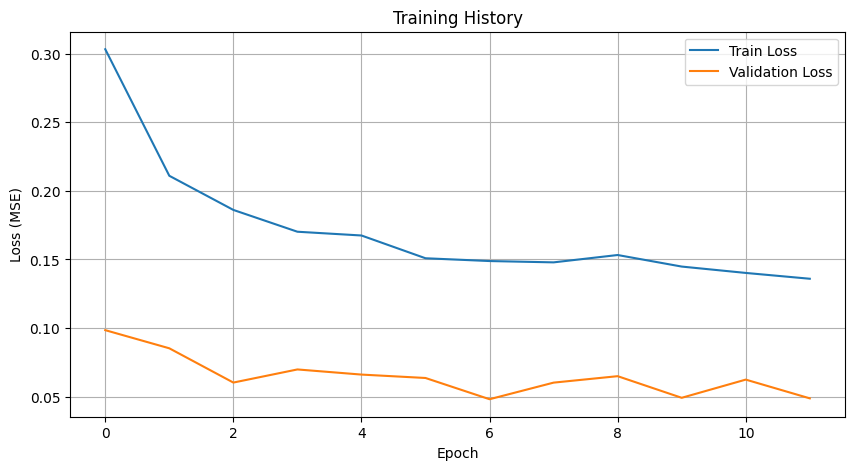

In [12]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

## 5. Anomaly Detection Evaluation

In [13]:
# Load best model
model.load_state_dict(torch.load('../../results/models/best_autoencoder_cicids2017.pth'))
model.eval()

# Calculate reconstruction errors on test set
reconstruction_errors = []
X_test_tensor = torch.FloatTensor(X_test).to(device)

with torch.no_grad():
    batch_size = 1024
    for i in range(0, len(X_test_tensor), batch_size):
        batch = X_test_tensor[i:i+batch_size]
        reconstructed = model(batch)
        # MSE per sample
        mse = torch.mean((batch - reconstructed) ** 2, dim=1)
        reconstruction_errors.extend(mse.cpu().numpy())

reconstruction_errors = np.array(reconstruction_errors)
print(f"Reconstruction errors shape: {reconstruction_errors.shape}")

C:\Users\musab\AppData\Local\Temp\ipykernel_40664\3985469249.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../results/models/best_

Reconstruction errors shape: (505410,)


C:\Users\musab\AppData\Local\Temp\ipykernel_40664\1844925272.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([reconstruction_errors[y_test == 0], reconstruction_errors[y_test == 1]],


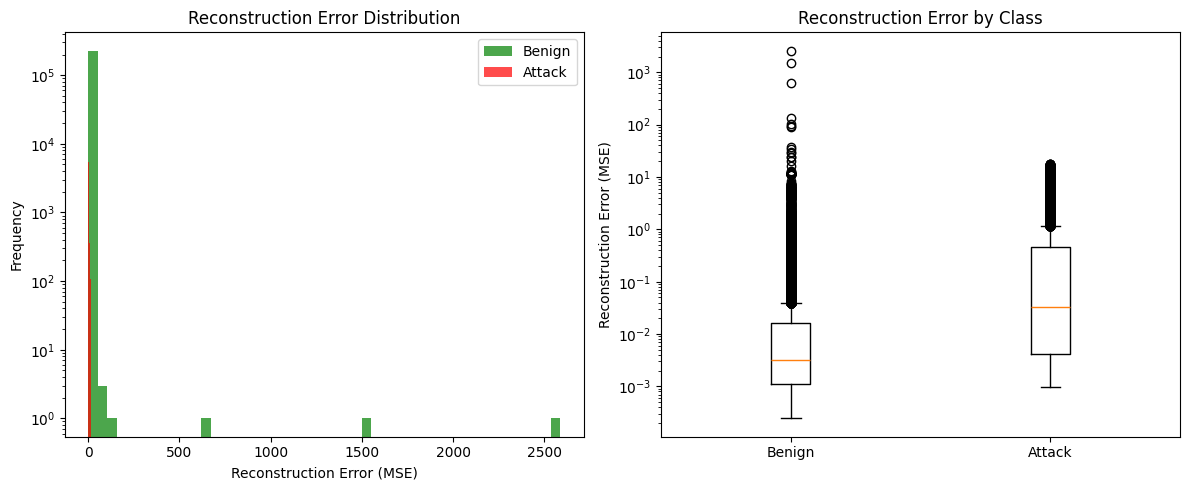

In [14]:
# Plot reconstruction error distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(reconstruction_errors[y_test == 0], bins=50, alpha=0.7, label='Benign', color='green')
plt.hist(reconstruction_errors[y_test == 1], bins=50, alpha=0.7, label='Attack', color='red')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.boxplot([reconstruction_errors[y_test == 0], reconstruction_errors[y_test == 1]], 
            labels=['Benign', 'Attack'])
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error by Class')
plt.yscale('log')

plt.tight_layout()
plt.show()

ROC AUC: 0.7867
Optimal threshold: 0.022398


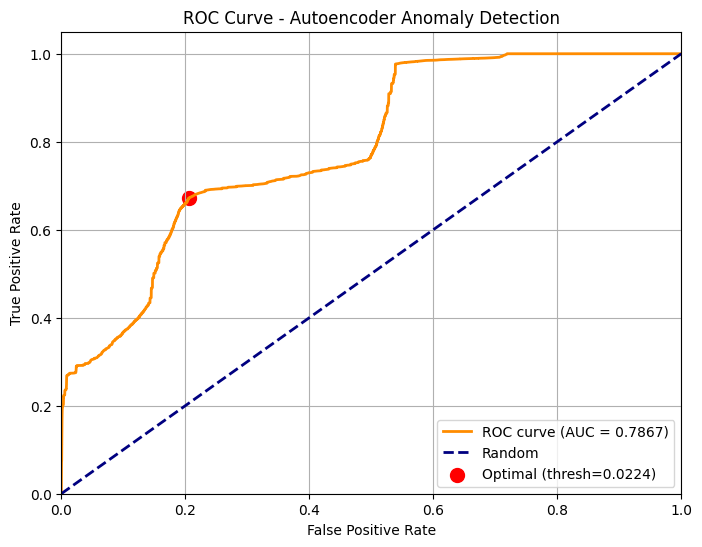

In [15]:
# Find optimal threshold using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors)
roc_auc = auc(fpr, tpr)

# Find threshold that maximizes TPR - FPR
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Optimal threshold: {optimal_threshold:.6f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100, 
            label=f'Optimal (thresh={optimal_threshold:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Autoencoder Anomaly Detection')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Classification Report:
              precision    recall  f1-score   support

      Benign       0.66      0.79      0.72    227132
      Attack       0.80      0.67      0.73    278278

    accuracy                           0.73    505410
   macro avg       0.73      0.73      0.73    505410
weighted avg       0.74      0.73      0.73    505410



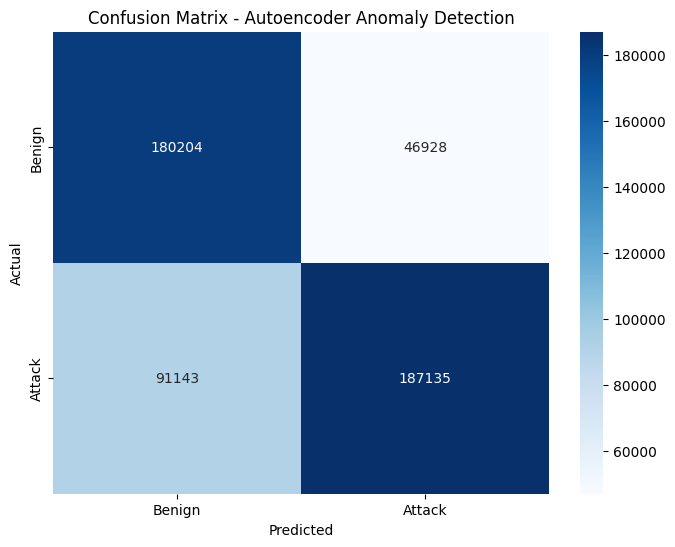

38427

In [16]:
# Classify based on threshold
predictions = (reconstruction_errors > optimal_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, predictions, target_names=['Benign', 'Attack']))

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], 
            yticklabels=['Benign', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Autoencoder Anomaly Detection')
plt.show()

# Cleanup
torch.cuda.empty_cache()
gc.collect()